# PROGETTO ANALISI DI IMMAGINI E VIDEO
## Notebook confronti


* **Lorenzo Defina** Matr: 205146 
* **Davide Medaglia** Matr: 207041

Questo notebook viene presentato per effettuare dei confronti di performance su diversi parametri e scelte progettuali. 
In questo caso è stato utilizzata una piccola porzione dell'intero dataset, diviso in train e test, ma comunque rapprsentativa mantenendo la stessa proporzione di video per ogni classe.   

In [3]:
SEED = 9126

import os
import json
import time
from datetime import datetime
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import DatasetFolder
from torchvision import transforms, datasets, models
import torchvision
from torchvision import datasets
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import cv2
from glob import glob
import shutil
import timeit
from datetime import datetime
from tqdm import tqdm
from PIL import Image
import gc
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

USE_CUDA = True
CUDA = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
if CUDA:
    print('run on %s' % device)
    

PyTorch Version:  1.5.1
Torchvision Version:  0.6.1
run on cuda


In [4]:
KEYSET_FILE ='./testset_keys_1lug2020.txt'
labels_dict = {0 : "block", 1 : "pass", 2 : "run", 3: "dribble",4: "shoot",
          5 : "ball in hand", 6 : "defense", 7: "pick" , 8 : "no_action" , 
          9: "walk" ,10: "discard"}

with open(os.path.join('.', 'annotation_dict.json')) as fp:  
    annotations = json.load(fp)    
print('N° di video totali: ',len(annotations))

with open(KEYSET_FILE) as fp:
    keys_test = json.load(fp)

annotationTraining = dict(filter(lambda x: x[0] not in keys_test, annotations.items()))
annotationTest = dict(filter(lambda x: x[0] in keys_test, annotations.items()))

len(annotations), len(annotationTraining), len(annotationTest)

N° di video totali:  37085


(37085, 25959, 11126)

Dallo split dei file 'annotation train' e 'annotation test' vengono estratti delle porzioni di dati mantenendo la stessa stratificazione.

In [5]:
_x, train_x, _y, train_y = train_test_split(list(annotationTraining.keys()), list(annotationTraining.values()),
                                                     test_size=0.01, random_state=SEED, stratify=list(annotationTraining.values()))

_x, test_x, _y, test_y = train_test_split(list(annotationTest.keys()), list(annotationTest.values()),
                                                     test_size=0.01, random_state=SEED, stratify=list(annotationTest.values()))

print('Dimensioni training set: ',len(train_x), len(train_y))
print('Dimensioni test set: ',len(test_x), len(test_y))

Dimensioni training set:  260 260
Dimensioni test set:  112 112


In [6]:
annotationTraining = dict(zip(train_x, train_y))
annotationTest = dict(zip(test_x, test_y))

Dalla cartella di examples separiamo i video in due cartelle 'Video Train' e 'Video Test'

In [ ]:
# lascio solo i file del piccolo train
def file_separation(FOLDER):
    name_folder = ['Video Train', 'Video Test']
    for name in name_folder:
        if not os.path.isdir(os.path.join(FOLDER, name)):
            os.mkdir(os.path.join(FOLDER, name))
    for root, dirs, files in os.walk(FOLDER):
        for name in files:
            DIR_SRC = os.path.join(FOLDER, name)
            vname = name.replace('.mp4', '') # elimino estensione nome
            
            if vname in train_x:
                DIR_DST = os.path.join(FOLDER, 'Video Train')
                shutil.move(DIR_SRC, DIR_DST)
            elif vname in test_x:
                DIR_DST = os.path.join(FOLDER, 'Video Test')
                shutil.move(DIR_SRC, DIR_DST)
            
            else:
                os.remove(DIR_SRC)
                
    print('DONE')


FOLDER = '.\examples2'
file_separation(FOLDER)


Per ogni cartella viene creata una suddivisione in 10 sotto-cartelle rappresentanti la 10 classi dei video in modo tale da avere per ogni sottocartella tutti i video appartenenti alla medesima classe.

In [8]:
# questa funzione crea le cartelle per le classi da 0 a 9
def create_dir_separation(DIR_SOURCE, numClass=10):
    for i in range(numClass):
        DIR_CLASS = os.path.join(DIR_SOURCE,'classe'+str(i))
        if not os.path.isdir(DIR_CLASS):
            os.mkdir(os.path.join(DIR_SOURCE,'classe'+str(i)))
            print('Creata classe {} esito: {}'.format(i, os.path.isdir(DIR_CLASS)))
    print('DONE')
        
# questa funzione sposta i video nelle cartelle delle classi
def class_separation(DIR_SOURCE, annotation):
    nameVideo = [f for f in os.listdir(DIR_SOURCE) if f.endswith('.mp4')]
    print(len(nameVideo))
    
    for name in nameVideo:
        nvideo = name.replace('.mp4','')
        classe = annotation[nvideo]
        FOLDER_SRC = os.path.join(DIR_SOURCE, name)
        FOLDER_DST = os.path.join(DIR_SOURCE,'classe'+str(classe))
        shutil.move(FOLDER_SRC, FOLDER_DST)
    
    print('DONE')


In [ ]:

# separiamo i video del training in classi
now = time.time()
DIR_SOURCE = './examples2/Video Train'
create_dir_separation(DIR_SOURCE)
print('-'*30)
class_separation(DIR_SOURCE, annotationTraining)      
print(time.time()-now)
print('DONE')


In [ ]:

# separiamo i video del test in classi
now = time.time()
DIR_SOURCE = './examples2/Video Test'
create_dir_separation(DIR_SOURCE)
print('-'*30)
class_separation(DIR_SOURCE, annotationTest)      
print(time.time()-now)
print('DONE')


## Funzioni di caricamento dei dati

VideoFolder è la classe incaricata di caricare i video e le label

In [11]:
VIDEO_EXTENSION = '.mp4'
# carico i video con le rispettive label
def video_loader(path):
    with open(path, 'rb') as f:
        video  = cv2.VideoCapture(path)
        return video
    
    

class VideoFolder(DatasetFolder):
    def __init__(self, root, transform=None, target_transform=None, loader=video_loader, is_valid_file=None):
        super(VideoFolder, self).__init__(root, loader, VIDEO_EXTENSION if is_valid_file is None else None,
                                          transform=transform,
                                          target_transform=None,
                                          is_valid_file=is_valid_file)
        self.video = self.samples

In [12]:
train = VideoFolder(root='./examples2/Video Train')
test = VideoFolder(root='./examples2/Video Test')

VideoDataset è la classe incaricata di estrarre i frame dai video e assegnare le corrispondenti label

In [13]:
class VideoDataset(Dataset):
    '''
    data = dizionario con video e label
    trasform=  trasformazione da applicare a tutti i 16 frame di un video
    '''
    def __init__(self, data, transform):
        self.transform = transform 
        self.data = data
        
    def __len__(self):
        return (len(self.data))
    
    def __getitem__(self, index):
        video, label = self.data[index]
        frames_sequence = []
        
        while True:
            ret, frame = video.read()
            if ret != True:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)
            # apply trasform
            frame = self.transform(frame)
            frames_sequence.append(frame)
        
        frames_sequence = torch.stack(frames_sequence)
        frames_sequence = torch.transpose(frames_sequence, 1, 0)
        
        return frames_sequence, label

In [14]:
transformer = transforms.Compose([transforms.Resize((112,112)),transforms.ToTensor()])

train_data = VideoDataset(data=train, transform=transformer)
test_data = VideoDataset(data=test, transform=transformer)
print('Dimensioni training: ', len(train_data))
print('Dimensioni test: ', len(test_data))

Dimensioni training:  260
Dimensioni test:  112


In [15]:
batch_size = 8

trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print('BATCH_SIZE: ', batch_size)
print('Dimensioni train loader: ', len(trainloader))
print('Dimensioni test loader: ', len(testloader))
print('-'*30)
trainiter = iter(trainloader)
features, labels = next(trainiter)
print(features.shape, labels.shape)

BATCH_SIZE:  8
Dimensioni train loader:  33
Dimensioni test loader:  14
------------------------------
torch.Size([8, 3, 16, 112, 112]) torch.Size([8])


## Rete ResNet3D
Come rete è stata scelta ResNet3D poichè è risultata essere la miglior architettura per la classificazione di video e l'action recognition.

In [16]:
class BasicStem(nn.Sequential):
    """The default conv-batchnorm-relu stem
    """
    def __init__(self):
        super(BasicStem, self).__init__(
            nn.Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True))

class Conv3DSimple(nn.Conv3d):
    def __init__(self,
                 in_planes,
                 out_planes,
                 midplanes=None,
                 stride=1,
                 padding=1):

        super(Conv3DSimple, self).__init__(
            in_channels=in_planes,
            out_channels=out_planes,
            kernel_size=(3, 3, 3),
            stride=stride,
            padding=padding,
            bias=False)

    def get_downsample_stride(stride):
        return (stride, stride, stride)


class BasicBlock(nn.Module):

    expansion = 1

    def __init__(self, inplanes, planes, conv_builder, stride=1, downsample=None):
        midplanes = (inplanes * planes * 3 * 3 * 3) // (inplanes * 3 * 3 + 3 * planes)

        super(BasicBlock, self).__init__()
        self.conv1 = nn.Sequential(
            conv_builder(inplanes, planes, midplanes, stride),
            nn.BatchNorm3d(planes),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            conv_builder(planes, planes, midplanes),
            nn.BatchNorm3d(planes)
        )
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class VideoResNet(nn.Module):

    def __init__(self, num_classes, block, conv_makers, layers, stem):
        '''
        Args:
            num_classes (int): dimensioni di output del layer fully-connected
            block (nn.Module): resnet building block
            conv_makers (list(functions)): generatore di funzione per ogni layer
            layers (List[int]): numeri di block per ogni layer
            stem (nn.Module, optional): Resnet stem
            
        '''
        super(VideoResNet, self).__init__()
        self.inplanes = 64

        self.stem = stem()

        self.layer1 = self._make_layer(block, conv_makers[0], 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, conv_makers[1], 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, conv_makers[2], 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, conv_makers[3], 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
    
       
    def forward(self, x):
        x = self.stem(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        # Flatten the layer to fc
        x = x.flatten(1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, conv_builder, planes, blocks, stride=1):
        downsample = None

        if stride != 1 or self.inplanes != planes * block.expansion:
            ds_stride = conv_builder.get_downsample_stride(stride)
            downsample = nn.Sequential(nn.Conv3d(self.inplanes, planes * block.expansion, 
                                                 kernel_size=1, stride=ds_stride, bias=False),
                                                nn.BatchNorm3d(planes * block.expansion))
        layers = []
        layers.append(block(self.inplanes, planes, conv_builder, stride, downsample))

        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, conv_builder))

        return nn.Sequential(*layers)

def ResNet3D(num_classes):
    return VideoResNet(num_classes, block=BasicBlock, conv_makers=[Conv3DSimple] * 4, layers=[2, 2, 2, 2], stem=BasicStem)

## Funzioni di training e validation

In [17]:
def accuracys_batch(target, output):    
    # obtain output class    
    pred = output.argmax(dim=1, keepdim=True)    
    # compare output class with target class    
    corrects = pred.eq(target.view_as(pred)).sum().item()    
    return corrects 

def loss_epoch(model, loss_func, dataset_dl, opt=None):    
    lossTot = 0.0   
    accuracy = 0.0
    acc_batch = []
    loss_batch = []
    
    for inputs, labels in dataset_dl:        
        inputs = Variable(inputs.to(device), requires_grad=True)       
        labels = Variable(labels.to(device), requires_grad=False)       
        predict = model(inputs)
        
        loss = loss_func(predict, labels) 
        loss_b = loss.item()
        
        accuracy_b = accuracys_batch(labels, predict)
        if opt is not None: # only training
            loss.backward()        
            opt.step()        
            opt.zero_grad()
        
        # stat
        loss_batch.append(loss_b)
        lossTot+=loss_b
        acc_batch.append(accuracy_b/batch_size * 100)
        if accuracy_b is not None:            
            accuracy+=accuracy_b
    
    lossTot /= len(dataset_dl)     
    accuracy /= len(dataset_dl.dataset)
    
    return lossTot, accuracy, acc_batch, loss_batch

In [18]:
def training(epochs, model, loss_func, opt, scheduler, train_dl, val_dl, nome):
    stat = pd.DataFrame(columns=['epoch', 'phase',  'train loss', 'loss batch', 'train acc', 'acc bath'])
    loss_func.to(device)
    for epoch in range(epochs):      
        # training
        model.train()      
        train_loss, train_metric, acc_batch, loss_batch = loss_epoch(model,loss_func,train_dl,opt)
        train_accuracy = train_metric*100
        print('TRAIN - Epoca[{}/{}] - train loss: {:.6f} ({:.6f}), train accuracy: {:.2f}'.format(epoch+1, epochs,
            train_loss, np.array(loss_batch).mean(), train_accuracy))
        stat = stat.append({'epoch':epoch, 'phase':'TRAIN', 'train loss':train_loss, 
                            'loss batch':loss_batch,'train acc':train_accuracy, 'acc bath':acc_batch}, ignore_index=True)
        
        # validation
        model.eval()        
        with torch.no_grad():            
            val_loss, val_metric, acc_batch, loss_batch = loss_epoch(model, loss_func, val_dl)        
            val_accuracy=100*val_metric

        print("  VALIDATION - Epoca {} - val loss: {:.6f} ({:.6f}), val accuracy: {:.2f} ({:.2f})".format((epoch+1), 
                            val_loss, np.array(loss_batch).mean(), val_accuracy, np.array(acc_batch).mean()) )
        
        stat = stat.append({'epoch':epoch, 'phase':'VALIDATION', 'valid loss':val_loss, 
                            'loss batch':loss_batch, 'valid acc':val_accuracy, 'acc bath':acc_batch}, ignore_index=True)
        
        # aggiusto learning rate
        scheduler.step(val_loss)
        
        # Empty cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    save_model(epoch, model, opt, loss_func, scheduler, nome)        
    stat.to_csv('./save/confronti/'+nome+'.csv', index=False)       
    return model

def save_model(epoch, model, opt, loss_func, scheduler,  name_model, save_dir='./save/confronti'):
    if not os.path.isdir(save_dir):
            os.mkdir('./save')
            os.mkdir('./save/confronti')
    
    torch.save({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'opt_dict': opt.state_dict(),
        'loss_dict': loss_func.state_dict(),
        'sheduler_dict': scheduler.state_dict()
    }, os.path.join(save_dir, name_model+'_epoch-' + str(epoch) + '.pth'))
    
    #stat.to_csv(os.path.join(save_dir, name_model+'_train_epoch-' + str(epoch) + '.csv'))
    print("Save model at {}".format(os.path.join(save_dir, name_model+'_epoch-' + str(epoch) + '.pth')))
   


Funzioni di plot dei risultati

In [19]:
def loss_plot(dt1, dt2, name1, name2):
    plt.figure(figsize=(16, 5))
    plt.subplot(1,3, 1)
    plt.plot(dt1[dt1['phase']=='TRAIN']['epoch'], dt1[dt1['phase']=='TRAIN']['train loss'], label=name1)
    plt.plot(dt2[dt2['phase']=='TRAIN']['epoch'], dt2[dt2['phase']=='TRAIN']['train loss'], label=name2)
    plt.title('Confronto Loss sul TRAINING')
    plt.xlabel('epoche')
    plt.ylabel('Loss')
    plt.legend(frameon=False)

    plt.subplot(1,3, 3)
    plt.plot(dt1[dt1['phase']=='VALIDATION']['epoch'], dt1[dt1['phase']=='VALIDATION']['valid loss'], label=name1)
    plt.plot(dt2[dt2['phase']=='VALIDATION']['epoch'], dt2[dt2['phase']=='VALIDATION']['valid loss'], label=name2)
    plt.title('Confronto Loss sul VALIDATION')
    plt.xlabel('epoche')
    plt.ylabel('Loss')
    plt.legend(frameon=False)
    plt.show();

In [20]:
def accuracy_plot(dt1, dt2, name1, name2):
    plt.figure(figsize=(16, 5))
    plt.subplot(1,3, 1)
    plt.plot(dt1[dt1['phase']=='TRAIN']['epoch'], dt1[dt1['phase']=='TRAIN']['train acc'], label=name1)
    plt.plot(dt2[dt2['phase']=='TRAIN']['epoch'], dt2[dt2['phase']=='TRAIN']['train acc'], label=name2)
    plt.title('Confronto accuracy sul TRAINING')
    plt.xlabel('epoche')
    plt.ylabel('Accuracy')
    plt.legend(frameon=False)

    plt.subplot(1,3, 3)
    plt.plot(dt1[dt1['phase']=='VALIDATION']['epoch'], dt1[dt1['phase']=='VALIDATION']['valid acc'], label=name1)
    plt.plot(dt2[dt2['phase']=='VALIDATION']['epoch'], dt2[dt2['phase']=='VALIDATION']['valid acc'], label=name2)
    plt.title('Confronto accuracy sul VALIDATION')
    plt.xlabel('epoche')
    plt.ylabel('Accuracy')
    plt.legend(frameon=False)
    plt.show();

# 1° CONFRONTO: _tipo di addestramento della rete_
## Addestramento _from scratch_ vs addestramento _fine-tuning_ (preaddestrato)

Come primo confronto viene paraganata la rete preaddestrata con una rete non preaddestrata.

I parametri di allenamento sono:
* **batch size**: 8
* **numero di epoche**: 8
* **funzione di loss**: CrossEntropyLoss()
* **learning rate**: 1e-3
* **scheduler**: ReduceLROnPlateau(patience=5, factor=0.1,)
* **optimizer**: SGD(momentum=0.9, weight_decay=5e-4)

Iniziamo con la rete preaddestrata effettuando _fine-tuning_

In [21]:
# i pesi sono compatibili con un numero di classe di output di 400
model_r3d = ResNet3D(num_classes=400)
model_r3d.load_state_dict(torch.load('./r3d_18-b3b3357e.pth', map_location='cpu'))

# Freeze layer
# Per impedire l'aggiornamento dei pesi del modello escludiamo i relativi tensori dal grafo di computazione
for param in model_r3d.parameters():
    param.requires_grad = False
n_inputs = model_r3d.fc.in_features
model_r3d.fc = nn.Linear(n_inputs, 10, bias=True)
model_r3d.to(device)

# Parametri:
lr=1e-3 # Learning rate
criterion = nn.CrossEntropyLoss()   
optimizer = optim.SGD(model_r3d.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, min_lr=1e-6) 
num_epochs=8

In [22]:
nome_prova = 'ResNet3D pre-addestrata'
model_r3d_trained = training(num_epochs, model=model_r3d, loss_func=criterion, opt=optimizer, scheduler=scheduler, train_dl=trainloader , val_dl=testloader, nome=nome_prova)

TRAIN - Epoca[1/8] - train loss: 2.059209 (2.059209), train accuracy: 27.69
  VALIDATION - Epoca 1 - val loss: 1.927887 (1.927887), val accuracy: 27.68 (27.68)
TRAIN - Epoca[2/8] - train loss: 1.859366 (1.859366), train accuracy: 32.31
  VALIDATION - Epoca 2 - val loss: 1.838588 (1.838588), val accuracy: 33.93 (33.93)
TRAIN - Epoca[3/8] - train loss: 1.733559 (1.733559), train accuracy: 38.46
  VALIDATION - Epoca 3 - val loss: 1.884565 (1.884565), val accuracy: 33.04 (33.04)
TRAIN - Epoca[4/8] - train loss: 1.669672 (1.669672), train accuracy: 39.62
  VALIDATION - Epoca 4 - val loss: 1.842564 (1.842564), val accuracy: 36.61 (36.61)
TRAIN - Epoca[5/8] - train loss: 1.555085 (1.555085), train accuracy: 47.31
  VALIDATION - Epoca 5 - val loss: 1.734268 (1.734268), val accuracy: 36.61 (36.61)
TRAIN - Epoca[6/8] - train loss: 1.493623 (1.493623), train accuracy: 50.77
  VALIDATION - Epoca 6 - val loss: 1.699884 (1.699884), val accuracy: 42.86 (42.86)
TRAIN - Epoca[7/8] - train loss: 1.41132

Usiamo la rete non preaddestrata allenandola _from scratch_

In [23]:
model_r3d = ResNet3D(num_classes=10)
model_r3d.to(device)

# Parametri:
lr=1e-3 # Learning rate
criterion = nn.CrossEntropyLoss()   
optimizer = optim.SGD(model_r3d.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, min_lr=1e-6) 
num_epochs=8

In [24]:
nome_prova = 'ResNet3D scratch'
model_r3d_trained = training(num_epochs, model=model_r3d, loss_func=criterion, opt=optimizer, scheduler=scheduler, train_dl=trainloader , val_dl=testloader, nome=nome_prova)

TRAIN - Epoca[1/8] - train loss: 2.050630 (2.050630), train accuracy: 29.23
  VALIDATION - Epoca 1 - val loss: 1.840850 (1.840850), val accuracy: 32.14 (32.14)
TRAIN - Epoca[2/8] - train loss: 1.906054 (1.906054), train accuracy: 31.15
  VALIDATION - Epoca 2 - val loss: 2.123390 (2.123390), val accuracy: 21.43 (21.43)
TRAIN - Epoca[3/8] - train loss: 1.715178 (1.715178), train accuracy: 36.92
  VALIDATION - Epoca 3 - val loss: 2.620155 (2.620155), val accuracy: 26.79 (26.79)
TRAIN - Epoca[4/8] - train loss: 1.706244 (1.706244), train accuracy: 37.69
  VALIDATION - Epoca 4 - val loss: 2.547120 (2.547120), val accuracy: 27.68 (27.68)
TRAIN - Epoca[5/8] - train loss: 1.419403 (1.419403), train accuracy: 54.23
  VALIDATION - Epoca 5 - val loss: 2.178154 (2.178154), val accuracy: 34.82 (34.82)
TRAIN - Epoca[6/8] - train loss: 1.216482 (1.216482), train accuracy: 58.85
  VALIDATION - Epoca 6 - val loss: 2.826464 (2.826464), val accuracy: 25.00 (25.00)
TRAIN - Epoca[7/8] - train loss: 1.30526

In [25]:
scratch = pd.read_csv('./save/confronti/ResNet3D scratch.csv')
tuning = pd.read_csv('./save/confronti/ResNet3D pre-addestrata.csv')

## Grafici 1° confronto

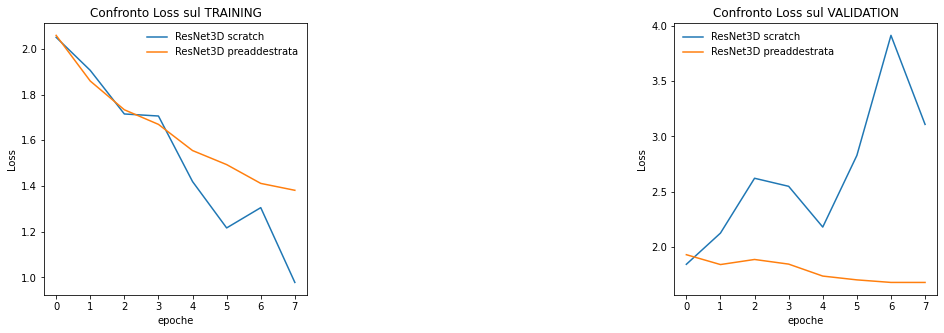

In [24]:
loss_plot(scratch, tuning, 'ResNet3D scratch','ResNet3D preaddestrata' )

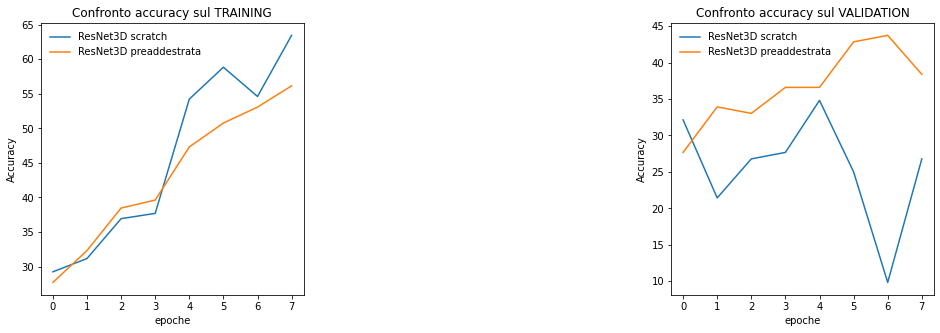

In [25]:
accuracy_plot(scratch, tuning, 'ResNet3D scratch','ResNet3D preaddestrata' )

### Considerazioni
Dal confronto effettuato risulta evidente come l'utilizzo di una rete preaddestrata risulta essere vantaggiosa poichè è in grado di generalizzare maggiormente rispetto alla rete addestrata _from scratch_.

# 2° CONFRONTO: _funzione di loss_
## CrossEntropy pesata sulle classi vs CrossEntropy non pesata


I parametri di allenamento sono:
* **batch size**: 8
* **numero di epoche**: 8
* **learning rate**: 1e-3
* **scheduler**: ReduceLROnPlateau(patience=5, factor=0.1,)
* **optimizer**: SGD(momentum=0.9, weight_decay=5e-4)
* **rete pre-addestrata**

**Funzione di loss pesata sulle classi**

In [26]:
# i pesi sono compatibili con un numero di classe di output di 400
model_r3d = ResNet3D(num_classes=400)
model_r3d.load_state_dict(torch.load('./r3d_18-b3b3357e.pth', map_location='cpu'))

# Freeze layer
# Per impedire l'aggiornamento dei pesi del modello escludiamo i relativi tensori dal grafo di computazione
for param in model_r3d.parameters():
    param.requires_grad = False
n_inputs = model_r3d.fc.in_features
model_r3d.fc = nn.Linear(n_inputs, 10, bias=True)
model_r3d.to(device)

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [27]:
from sklearn.utils.class_weight import compute_class_weight
# Learning rate
lr=1e-3 

# Crossentropy loss pesata
weights = compute_class_weight('balanced', np.unique(list(annotationTraining.values())),[label[1] for label in annotationTraining.items() ])
class_weights = torch.FloatTensor(weights)
criterion = nn.CrossEntropyLoss(weight=class_weights)   

optimizer = optim.SGD(model_r3d.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

# lo scheduler il learning rate per 0.1 ogni 5 epoche
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, min_lr=1e-6) 

num_epochs=8

In [28]:
nome_prova = 'Loss pesata'
model_r3d_trained = training(num_epochs, model=model_r3d, loss_func=criterion, opt=optimizer, scheduler=scheduler, train_dl=trainloader , val_dl=testloader, nome=nome_prova)

TRAIN - Epoca[1/8] - train loss: 2.433528 (2.433528), train accuracy: 14.23
  VALIDATION - Epoca 1 - val loss: 2.236968 (2.236968), val accuracy: 16.07 (16.07)
TRAIN - Epoca[2/8] - train loss: 2.201042 (2.201042), train accuracy: 18.85
  VALIDATION - Epoca 2 - val loss: 2.191767 (2.191767), val accuracy: 27.68 (27.68)
TRAIN - Epoca[3/8] - train loss: 2.037711 (2.037711), train accuracy: 27.31
  VALIDATION - Epoca 3 - val loss: 2.077584 (2.077584), val accuracy: 29.46 (29.46)
TRAIN - Epoca[4/8] - train loss: 1.885839 (1.885839), train accuracy: 31.92
  VALIDATION - Epoca 4 - val loss: 2.138078 (2.138078), val accuracy: 28.57 (28.57)
TRAIN - Epoca[5/8] - train loss: 1.727684 (1.727684), train accuracy: 41.92
  VALIDATION - Epoca 5 - val loss: 1.990589 (1.990589), val accuracy: 40.18 (40.18)
TRAIN - Epoca[6/8] - train loss: 1.616077 (1.616077), train accuracy: 49.23
  VALIDATION - Epoca 6 - val loss: 2.205711 (2.205711), val accuracy: 19.64 (19.64)
TRAIN - Epoca[7/8] - train loss: 1.61008

**Funzione di loss non pesata**

In [29]:
# i pesi sono compatibili con un numero di classe di output di 400
model_r3d = ResNet3D(num_classes=400)
model_r3d.load_state_dict(torch.load('./r3d_18-b3b3357e.pth', map_location='cpu'))

# Freeze layer
# Per impedire l'aggiornamento dei pesi del modello escludiamo i relativi tensori dal grafo di computazione
for param in model_r3d.parameters():
    param.requires_grad = False
n_inputs = model_r3d.fc.in_features
model_r3d.fc = nn.Linear(n_inputs, 10, bias=True)
model_r3d.to(device)

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [30]:
# Learning rate
lr=1e-3 
criterion = nn.CrossEntropyLoss()   
optimizer = optim.SGD(model_r3d.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, min_lr=1e-6) 
num_epochs=8

In [31]:
nome_prova = 'Loss non pesata'
model_r3d_trained = training(num_epochs, model=model_r3d, loss_func=criterion, opt=optimizer, scheduler=scheduler, train_dl=trainloader , val_dl=testloader, nome=nome_prova)

TRAIN - Epoca[1/8] - train loss: 2.134756 (2.134756), train accuracy: 26.92
  VALIDATION - Epoca 1 - val loss: 1.859685 (1.859685), val accuracy: 33.04 (33.04)
TRAIN - Epoca[2/8] - train loss: 1.818710 (1.818710), train accuracy: 35.38
  VALIDATION - Epoca 2 - val loss: 1.802287 (1.802287), val accuracy: 36.61 (36.61)
TRAIN - Epoca[3/8] - train loss: 1.735747 (1.735747), train accuracy: 36.54
  VALIDATION - Epoca 3 - val loss: 1.751529 (1.751529), val accuracy: 41.07 (41.07)
TRAIN - Epoca[4/8] - train loss: 1.641131 (1.641131), train accuracy: 41.54
  VALIDATION - Epoca 4 - val loss: 1.739535 (1.739535), val accuracy: 38.39 (38.39)
TRAIN - Epoca[5/8] - train loss: 1.558392 (1.558392), train accuracy: 47.69
  VALIDATION - Epoca 5 - val loss: 1.716239 (1.716239), val accuracy: 38.39 (38.39)
TRAIN - Epoca[6/8] - train loss: 1.524112 (1.524112), train accuracy: 43.85
  VALIDATION - Epoca 6 - val loss: 1.727064 (1.727064), val accuracy: 39.29 (39.29)
TRAIN - Epoca[7/8] - train loss: 1.41031

## Grafici 2° confronto 

In [32]:
noPesi = pd.read_csv('./save/confronti/LossNoPeso.csv')
pesi = pd.read_csv('./save/confronti/LossPeso.csv')

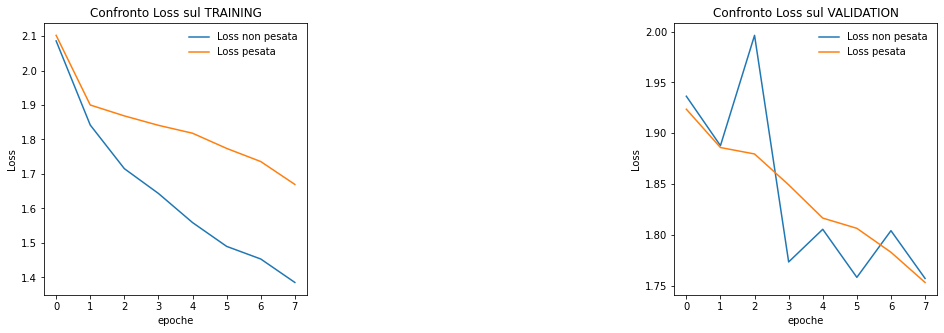

In [34]:
loss_plot(noPesi, pesi, 'Loss non pesata', 'Loss pesata')

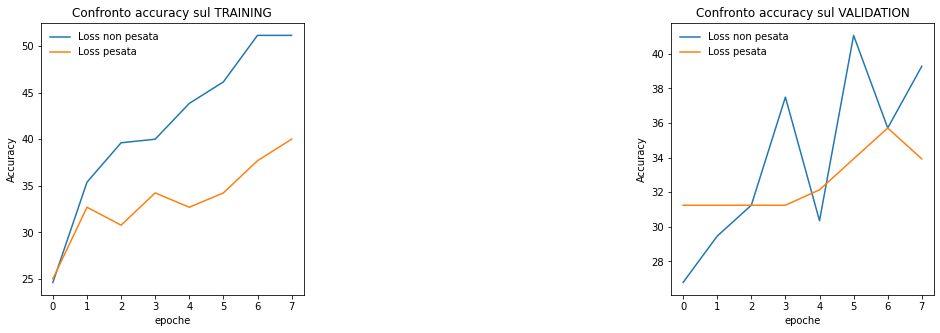

In [35]:
accuracy_plot(noPesi, pesi, 'Loss non pesata', 'Loss pesata')

### Considerazioni
Dal confronto tra le due diverse funzioni di loss è emerso che nonstante nel dataset ci siano classi sblilanciate non è molto rilevante l'introduzione della loss basata sui pesi delle classi. 

# 3° CONFRONTO: _metodo di ottimizzazione_
## Adam (Adaptive Moment Estimation) vs SGD (Stochastic Gradient Descent)

I parametri di allenamento sono:
* **batch size**: 8
* **numero di epoche**: 8
* **learning rate**: 1e-3
* **scheduler**: ReduceLROnPlateau(patience=5, factor=0.1,)
* **funzione di loss**: CrossEntropyLoss()
* **rete pre-addestrata**

**Ottimizzazione ADAM**

In [36]:
# i pesi sono compatibili con un numero di classe di output di 400
model_r3d = ResNet3D(num_classes=400)
model_r3d.load_state_dict(torch.load('./r3d_18-b3b3357e.pth', map_location='cpu'))

# Freeze layer
# Per impedire l'aggiornamento dei pesi del modello escludiamo i relativi tensori dal grafo di computazione
for param in model_r3d.parameters():
    param.requires_grad = False
n_inputs = model_r3d.fc.in_features
model_r3d.fc = nn.Linear(n_inputs, 10, bias=True)
   

In [37]:
model_r3d.to(device)

# Learning rate
lr=1e-3 
criterion = nn.CrossEntropyLoss()   
optimizer = optim.Adam(model_r3d.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, min_lr=1e-6) 
num_epochs=8


In [38]:
nome_prova = 'ADAM'
model_r3d_trained = training(num_epochs, model=model_r3d, loss_func=criterion, opt=optimizer, scheduler=scheduler, train_dl=trainloader , val_dl=testloader, nome=nome_prova)

TRAIN - Epoca[1/8] - train loss: 2.094163 (2.094163), train accuracy: 27.69
  VALIDATION - Epoca 1 - val loss: 1.926640 (1.926640), val accuracy: 34.82 (34.82)
TRAIN - Epoca[2/8] - train loss: 1.843320 (1.843320), train accuracy: 35.00
  VALIDATION - Epoca 2 - val loss: 1.846561 (1.846561), val accuracy: 33.04 (33.04)
TRAIN - Epoca[3/8] - train loss: 1.698820 (1.698820), train accuracy: 36.92
  VALIDATION - Epoca 3 - val loss: 1.824556 (1.824556), val accuracy: 33.04 (33.04)
TRAIN - Epoca[4/8] - train loss: 1.648022 (1.648022), train accuracy: 39.62
  VALIDATION - Epoca 4 - val loss: 1.776650 (1.776650), val accuracy: 34.82 (34.82)
TRAIN - Epoca[5/8] - train loss: 1.575073 (1.575073), train accuracy: 44.62
  VALIDATION - Epoca 5 - val loss: 1.743480 (1.743480), val accuracy: 38.39 (38.39)
TRAIN - Epoca[6/8] - train loss: 1.452028 (1.452028), train accuracy: 48.85
  VALIDATION - Epoca 6 - val loss: 1.722202 (1.722202), val accuracy: 40.18 (40.18)
TRAIN - Epoca[7/8] - train loss: 1.37510

**Ottimizzazione SGD**

In [39]:
# i pesi sono compatibili con un numero di classe di output di 400
model_r3d = ResNet3D(num_classes=400)
model_r3d.load_state_dict(torch.load('./r3d_18-b3b3357e.pth', map_location='cpu'))

# Freeze layer
# Per impedire l'aggiornamento dei pesi del modello escludiamo i relativi tensori dal grafo di computazione
for param in model_r3d.parameters():
    param.requires_grad = False
n_inputs = model_r3d.fc.in_features
model_r3d.fc = nn.Linear(n_inputs, 10, bias=True)
model_r3d.to(device)

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [40]:
# Learning rate
lr=1e-3 
criterion = nn.CrossEntropyLoss()   
optimizer = optim.SGD(model_r3d.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, min_lr=1e-6) 
num_epochs=8

In [41]:
nome_prova = 'SGD'
model_r3d_trained = training(num_epochs, model=model_r3d, loss_func=criterion, opt=optimizer, scheduler=scheduler, train_dl=trainloader , val_dl=testloader, nome=nome_prova)

TRAIN - Epoca[1/8] - train loss: 2.074655 (2.074655), train accuracy: 26.54
  VALIDATION - Epoca 1 - val loss: 1.913735 (1.913735), val accuracy: 29.46 (29.46)
TRAIN - Epoca[2/8] - train loss: 1.871905 (1.871905), train accuracy: 34.23
  VALIDATION - Epoca 2 - val loss: 1.805978 (1.805978), val accuracy: 31.25 (31.25)
TRAIN - Epoca[3/8] - train loss: 1.740023 (1.740023), train accuracy: 38.08
  VALIDATION - Epoca 3 - val loss: 1.756415 (1.756415), val accuracy: 38.39 (38.39)
TRAIN - Epoca[4/8] - train loss: 1.628214 (1.628214), train accuracy: 45.00
  VALIDATION - Epoca 4 - val loss: 1.706228 (1.706228), val accuracy: 32.14 (32.14)
TRAIN - Epoca[5/8] - train loss: 1.546369 (1.546369), train accuracy: 46.92
  VALIDATION - Epoca 5 - val loss: 1.712739 (1.712739), val accuracy: 39.29 (39.29)
TRAIN - Epoca[6/8] - train loss: 1.496611 (1.496611), train accuracy: 47.31
  VALIDATION - Epoca 6 - val loss: 1.701300 (1.701300), val accuracy: 39.29 (39.29)
TRAIN - Epoca[7/8] - train loss: 1.48170

## Grafici 3° confronto

In [42]:
SGD = pd.read_csv('./save/confronti/SGD.csv')
adam = pd.read_csv('./save/confronti/ADAM.csv')

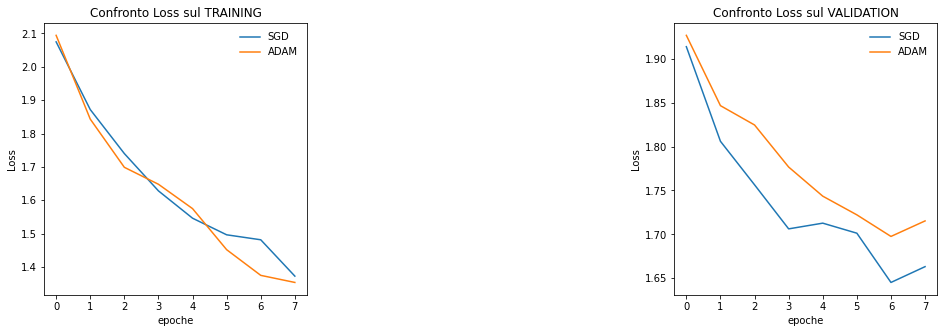

In [44]:
loss_plot(SGD, adam, 'SGD','ADAM')

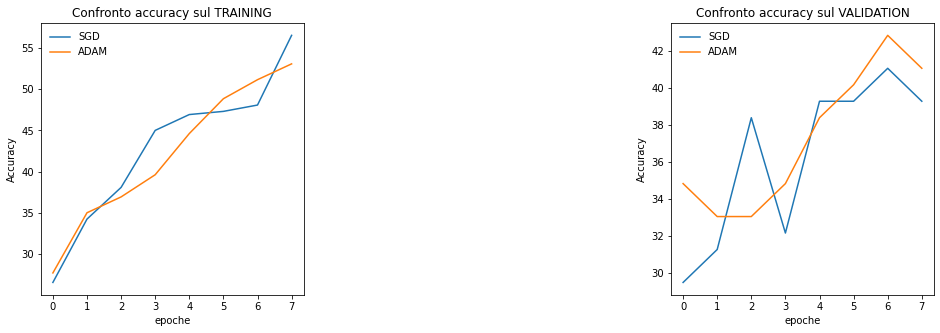

In [48]:
accuracy_plot(SGD, adam, 'SGD','ADAM')

### Considerazioni
Nonostante nel paper di ResNet3D sia proposto l'utilizzo dell'ottimizzatore SGD (Stochastic Gradient Descent) dall'analisi fatta risulta più performante, nel caso di studio preso in esame, ADAM (Adaptive Moment Estimation) poichè presenta i vantiggi di maggior efficienza computazionale e minor uso di memoria.

# CONCLUSIONI

Alla fine di questa analisi si riportano i parametri e le scelte progettuali effettuate:
* **tipo di rete ResNet3D pre-addestrata**: usare una rete preaddestrata su un altro dataset aiuta a generalizzare maggiormente i dati
* **optimazer ADAM**: questo ottimizzatore è risultato essere più efficiente rispetto a SGD
* **funzione di loss CROSS ENTROPY non pesata**
* **learning rate**: 1e-3
* **scheduler**: ReduceLROnPlateau(patience=5, factor=0.1)